# Transfer Learning para clasificación de un dataset pequeño

Cargamos un dataset con imágenes de 3 categorías de osos:
- Osos Grizzly
- Osos Negros
- Osos de peluche

El dataset contiene 80 imágenes por categoría, un total de 240 imágenes.

Como test yo he acumulado 10 imágenes por categoría.

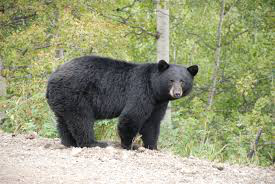

In [1]:
import os
import tensorflow as tf

tf.keras.backend.clear_session()

from tensorflow.keras.preprocessing import image
base_path = 'C:/Users/etesone/Desktop/MASTER UCM/Deep Learning/datasets/practicas/osos'
image.load_img(base_path + '/black/00000034.jpg')

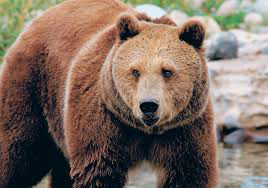

In [2]:
image.load_img(base_path + '/grizzly/00000020.jpg')

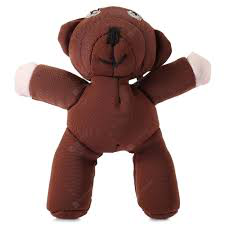

In [3]:
image.load_img(base_path + '/teddys/00000037.jpg')

### Elección de modelo

Para seleccionar los modelos a probar intente con algunos modelos con pocas cantidades de parámetros y otros con mayores cantidades.

- Utilizando MobileNet conseguí un máximo de accuracy de .8917 con menos de 4 millones de parámetros entrenables
- InceptionResNetV2 dio un accuracy de .6103 con un target de (224,224) y limitado a 788 mil parámetros entrenables
    - He probado con un target de (331,331) y tarda 5 minutos por epoch, por lo tanto fue descartado este modelo
- NASNetLarge tarda 10 minutos por epoch limitando los parámetros entrenables, por lo tanto fue descartado este modelo
- ResNet50 con un millón de parámetros entrenables dio un accuracy máximo de .9583.
- Xception con un millón de parámetros entrenables dio un accuracy máximo de .7344, por lo tanto fue descartado este modelo
- VGG16 dio un accuracy de .9896 con poco mas de 250 mil parámetros. Este modelo fue seleccionado para mejorar y llegar al 1.0.

In [4]:
import pandas as pd
import numpy as np
import keras

from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet, VGG16, InceptionResNetV2, NASNetLarge, ResNet50, Xception

#base_model=MobileNet(weights='imagenet',include_top=False)
base_model=VGG16(weights='imagenet', include_top=False)
#base_model=InceptionResNetV2(weights='imagenet', include_top=False)
#base_model=NASNetLarge(weights='imagenet', include_top=False)
#base_model=ResNet50(weights='imagenet', include_top=False)
#base_model=Xception(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x) #dense layer 3
preds = Dense(3, activation='softmax')(x) #final layer with softmax activation

Using TensorFlow backend.


In [5]:
from keras.models import Model

model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [6]:
len (base_model.layers)

19

In [7]:
len(model.layers)

22

In [8]:
for layer in model.layers[:19]:
    layer.trainable=False
for layer in model.layers[19:]:
    layer.trainable=True
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

### Elección de argumentos

- Con un target_size de (224,224), el modelo VGG16 tiene un accuracy máximo de .9896. Al subir el target_size a (331,331), el accuracy máximo del train es de 1.0, mientras que el accuracy del set de validación llega a .9583, lo cual es de esperar dado el tamaño del set de validación (20% del dataset).
    - Estos valores cambian con cada repetición

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from keras.applications.inception_resnet_v2 import preprocess_input as preprocess_InceptionResNetV2
from keras.applications.nasnet import preprocess_input as preprocess_NASNetLarge
from keras.applications.resnet50 import preprocess_input as preprocess_ResNet50
from keras.applications.xception import preprocess_input as preprocess_Xception


#train_datagen=ImageDataGenerator(preprocessing_function=preprocess_mobilenet, validation_split=0.2)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16, validation_split=0.2)
#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_InceptionResNetV2, validation_split=0.2)
#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_NASNetLarge, validation_split=0.2)
#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_ResNet50, validation_split=0.2)
#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_Xception, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(base_path, # this is where you specify the path to the main data folder
                                                    target_size=(331,331),
                                                    # default parameters
                                                    color_mode='rgb',
                                                    batch_size=2,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(331, 331),
        batch_size=2,
        class_mode='categorical',
        subset='validation')

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


In [10]:
from keras.optimizers import Adam

model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=5,
                    validation_data = validation_generator)

Epoch 1/5
96/96 [==============================] - 208s 2s/step - loss: 1.5435 - accuracy: 0.8385 - val_loss: 5.9605e-08 - val_accuracy: 0.9792
Epoch 2/5
96/96 [==============================] - 207s 2s/step - loss: 0.1215 - accuracy: 0.9740 - val_loss: 8.3446e-07 - val_accuracy: 0.9792
Epoch 3/5
96/96 [==============================] - 207s 2s/step - loss: 0.1382 - accuracy: 0.9583 - val_loss: 5.5140e-04 - val_accuracy: 0.9583
Epoch 4/5
96/96 [==============================] - 206s 2s/step - loss: 0.4547 - accuracy: 0.9323 - val_loss: 0.0066 - val_accuracy: 0.9583
Epoch 5/5
96/96 [==============================] - 206s 2s/step - loss: 0.2247 - accuracy: 0.9583 - val_loss: 1.1921e-07 - val_accuracy: 0.9792


teddys


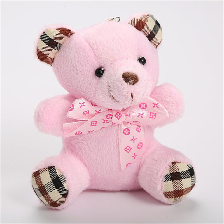

In [11]:
from numpy import expand_dims
import matplotlib.pyplot as plt

class_dict = {v:k for k, v in train_generator.class_indices.items()}

def predict_image(path):
    img = image.load_img(path)
    img = img.resize((224, 224))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_vgg16(data)
    preds = model.predict(data)
    pred = np.argmax(preds)
    pred = class_dict[pred]
    print(pred)
    return img
pred_path = 'C:/Users/etesone/Desktop/MASTER UCM/Deep Learning/datasets/practicas/Test'
predict_image(pred_path + '/Teddy/Custom-Bow-Teddy-Bear-Toy-for-Gift-Valentine-s-Day-Present-Plush-Teddy-Bear.jpg')

grizzly


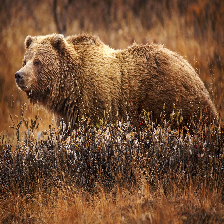

In [12]:
predict_image(pred_path + '/Grizzly/GrizzlyBearJeanBeaufort.jpg')

black


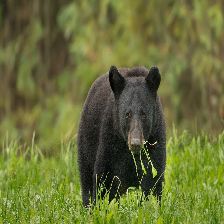

In [13]:
predict_image(pred_path + '/Black/black_bear_louisiana_clint_turnage_fws.jpg')

teddys


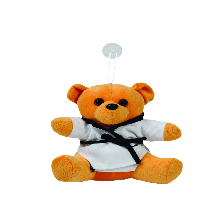

In [14]:
predict_image(pred_path + '/Teddy/karate-teddy-bear.jpg')

black


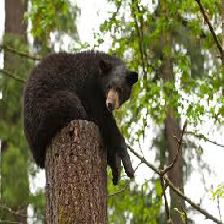

In [15]:
predict_image(pred_path + '/Black/images (1).jpg')

In [16]:
import os
path  = pred_path + '/Teddy'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            predict_image(new_path)

teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys


In [17]:
path  = pred_path + '/Grizzly'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            predict_image(new_path)

grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly


In [18]:
path  = pred_path + '/Black'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            predict_image(new_path)

black
black
black
black
black
black
black
black
black
black
